# Import libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm_notebook

# %matplotlib inline
%matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("/home/leo/Downloads/plasticc_torch/src/")
from plasticc_dataset_torch import get_plasticc_datasets
from plasticc_plotting import plot_light_curve

# Load data

In [54]:
# define path to dataset

# path to file in guanaco
# pathToFile = "/home/shared/astro/PLAsTiCC/"

# path to file in local 
# pathToFile = "/home/leo/Desktop/plasticc_dataset/"
pathToFile = "/home/leo/Downloads/plasticc_torch/"

## Loading dataset with pytorch tool

In [55]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=[16, 92])

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 2 csv files at given path


# Ploting one light curve

In [56]:
lc_data, lc_label, lc_plasticc_id = torch_dataset_lazy.__getitem__(123)
# display(lc_plasticc_id, lc_label)
# 6 bands: u g r i z Y
# 4 sequences: mjd, flux, error, mask
# 72 samples
display(lc_data.shape, lc_data.dtype)
print(lc_data.detach().numpy()[0, 0, :])

torch.Size([6, 4, 72])

torch.float32

[59582.33  59583.242 59584.242 59585.234 59586.24  59645.1   59670.008
 59701.99  59702.984 59704.066 59968.195 59997.133 59998.11  59999.113
 60027.062 60028.05  60029.08  60051.008 60051.996 60052.996 60053.996
 60054.996 60055.992 60056.992 60079.99  60381.21  60382.11  60383.125
 60435.984 60436.984     0.        0.        0.        0.        0.
     0.        0.        0.        0.        0.        0.        0.
     0.        0.        0.        0.        0.        0.        0.
     0.        0.        0.        0.        0.        0.        0.
     0.        0.        0.        0.        0.        0.        0.
     0.        0.        0.        0.        0.        0.        0.
     0.        0.   ]


In [57]:
plot_light_curve(torch_dataset_lazy, index_in_dataset=1234)

<IPython.core.display.Javascript object>

# Standarizing data

### <font color='red'>Things to do:</font>
- Is the StandarScaler correct?

In [58]:
# # standarizing variables
# # this returns a numpy array
# stdLightCurves = StandardScaler().fit_transform(lightCurves.loc[:, ["flux", "flux_err"]])
# display(stdLightCurves.shape)

# # create new array wth standarized data
# lightCurvesStd = lightCurves
# # overwrite data
# lightCurvesStd["flux"] = stdLightCurves[:, 0]
# lightCurvesStd["flux_err"] = stdLightCurves[:, 1]

# #printing dataset
# display(lightCurvesStd.head())

# Spliting data (train/test)

In [59]:
# # Spliting the data

# # selecting train splitting
# train_size = int(0.8 * lightCurvesById.shape[0])

# # getting test splitting
# test_size = lightCurvesById.shape[0] - train_size

# # spliting the torch dataset
# trainDataset, testDataset = torch.utils.data.random_split(dataset, [train_size, test_size])

## Create a dataloader

In [60]:
# # Create data loader (minibatches)

# # train loader
# trainLoader = data.DataLoader(trainDataset, batch_size=256)

# # test loader
# testLoader = data.DataLoader(testDataset)
trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

In [61]:
# check data loader shape
# display(list(trainLoader)[0][0].shape)

# display(list(trainLoader)[0][1].shape)

# display(list(trainLoader)[0][2].shape)

display(list(trainLoader)[0][0].shape)

torch.Size([256, 6, 4, 72])

## Define autoencoder structure
To start with the work, It is going to build a very basic Autoencoder

### <font color='red'>Things to do:</font>
- should we use shared weights or different layers in convolution?

In [124]:
# Buiding autoencoder

# Assuming this has a normal distrubtion in the latent part

# encoder
class Encoder(torch.nn.Module):
    
    # init method
    def __init__(self, latent_dim, hidden_dim, input_dim):

        super(Encoder, self).__init__()
        
        # 1 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv1 = torch.nn.Conv1d(1,64,3)
        
        # this is to consider time and magnitude
        # we should use shared weights?
        self.conv1Time = torch.nn.Conv1d(1, 64, 3)
        self.conv1Mag = torch.nn.Conv1d(1, 64, 3)
        
        # 2 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv2 = torch.nn.Conv1d(64, 32, 3)
        
        # time and magnitude conv
        self.conv2Time = torch.nn.Conv1d(64, 32, 3)
        self.conv2Mag = torch.nn.Conv1d(64, 32, 3)
        
        # linear layer
        self.hidden1 = torch.nn.Linear(2144*2, hidden_dim)
        
        # mu
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        
        # sigma
        self.logVar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()

    # forward method
    def forward(self, x):
            
#         print("input shape: {0}".format(x.shape))
        
        # select channel
        # select time and flux
#         x = x[:, 0, 0:2, :]
        
#         print("input shape: {0}".format(x.shape))
        
        # Input shape to conv:
        # [batch_size, channels, sequence_length]
        # reshapa data (add number of channels)
        # shape should be: [batch_size, 1 channel, lenght of light curve (50)]
#         x = x.unsqueeze(1)
        
#         print("input reshape: {0}".format(x.shape))
        
        # convolution 1
        # x -> conv -> act -> ouput
        # shape should be: [batch_size, number of ouput channels (64), length of output from convolution]
#         output = self.activationConv(self.conv1(x))
        
#         print("input to conv 1 time: {0}".format(x[:, 0, :].unsqueeze(1).shape))
        
        #conv to time
        outputTimeConv = self.activationConv(self.conv1Time(x[:, 0, :].unsqueeze(1)))
#         outputTimeConv = self.activationConv(self.conv1(x[:, 0, :]))
#         outputTimeConv = self.activationConv(self.conv1(x[:, 0, :]))
        
        
        # conv to magnitude
        outputMagConv = self.activationConv(self.conv1Mag(x[:, 0, :].unsqueeze(1)))
#         outputMagConv = self.activationConv(self.conv1(x[:, 1, :]))
#         outputMagConv = self.activationConv(self.conv1(x[:, 1, :]))
        
#         print("output conv1 shape: {0}".format(outputMagConv.shape))
#         print("output conv1 shape: {0}".format(outputTimeConv.shape))
        
        # convolution 2
#         # shape should be: [batch_size, number of ouput channels (32), length of output from convolution]
#         output = self.activationConv(self.conv2(output))
#         outputMagConv = self.activationConv(self.conv2Mag(outputMagConv))
        outputMagConv = self.activationConv(self.conv2(outputMagConv))
#         outputTimeConv = self.activationConv(self.conv2Time(outputTimeConv))
        outputTimeConv = self.activationConv(self.conv2(outputTimeConv))
    
#         print("output conv2 shape: {0}".format(outputTimeConv.shape))
#         print("output conv2 shape: {0}".format(outputMagConv.shape))
        
        # flatten ouput
        # shape should be: [batch_size, -1]
#         output = output.view(output.shape[0], -1)
        # flatten tower 1
        outputMagConv = outputMagConv.view(outputMagConv.shape[0], -1)
        outputTimeConv = outputTimeConv.view(outputTimeConv.shape[0], -1)
        
#         print("output reshape: ", outputMagConv.shape)
#         print("output reshape: ", outputTimeConv.shape)
                
        # concatenate 2 towers
        output = torch.cat((outputMagConv, outputTimeConv), 1)
#         print("concatenate output shape: ", output.shape)
        
        # x -> hidden1 -> activation
        output = self.activationLinear(self.hidden1(output))
#         print("hidden1 output shape: {0}".format(output.shape))
        
#         output = self.activation(self.hidden2(output))
        
        # get mu
        # sin tangenteh!!!
        mu = self.mu(output)
#         print("mu shape: {0}".format(mu.shape))
        
        # get sigma
        # parametrizar logaritmo de sigma (y después  en el sampligng se obtiene exponencial)
        logVar = self.logVar(output)
#         print("sigma shape: {0}".format(logVar.shape))
        
        # returning values
        return mu, logVar

    
# decoder    
class Decoder(torch.nn.Module):
    
    # define layers
    def __init__(self, latent_dim, hidden_dim, output_dim):
        
        super(Decoder, self).__init__()
        
        # linear layer
        self.hidden1 = torch.nn.Linear(latent_dim, 2144*2)
        
        # 1 ConvolutionTrans layer
        self.convTrans1 = torch.nn.ConvTranspose1d(32, 64, 3)
        
        # 2 ConvolutionTrans layer
        self.convTrans2 = torch.nn.ConvTranspose1d(64, 1, 3)

        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()
        
    # forward method
    def forward(self, z):
        
#         print("input dimension decoder: {0}".format(z.shape))
        
        # linear (from latent to hidden dimension)
        # z -> linaer layer -> activation -> output
        output = self.activationLinear(self.hidden1(z))
#         print("output hidden1: {0}".format(output.shape))
        
        # split data
        outputTimeDeconv, outputMagDeconv = torch.split(output, 2144, dim=2)
        
        # reshape (I don't know if it is correct)
        # output = output.view(output.shape[0], 1, -1)
#         output = output.view(output.shape[0], 32, -1)
        outputTimeDeconv = outputTimeDeconv.view(outputTimeDeconv.shape[0], 32, -1)
        outputMagDeconv = outputMagDeconv.view(outputMagDeconv.shape[0], 32, -1)
        
#         print("output reshape: {0}".format(outputTimeDeconv.shape))
#         print("output reshape: {0}".format(outputMagDeconv.shape))
        
        # 1 convolution
#         output = self.activationConv(self.convTrans1(output))
        outputTimeDeconv = self.activationConv(self.convTrans1(outputTimeDeconv))
        outputMagDeconv = self.activationConv(self.convTrans1(outputMagDeconv))
#         print("ouput convTrans1: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans1: {0}".format(outputMagDeconv.shape))
        
        # 2 convolution
#         output = self.activationConv(self.convTrans2(output))
#         output = self.convTrans2(output)
        outputTimeDeconv = self.convTrans2(outputTimeDeconv)
        outputMagDeconv = self.convTrans2(outputMagDeconv)
        
#         print("ouput convTrans2: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans2: {0}".format(outputMagDeconv.shape))
        
#         # remove one dimensionl (channel)
#         outputTimeDeconv = outputTimeDeconv.view(outputTimeDeconv.shape[0], -1)
#         outputMagDeconv = outputMagDeconv.view(outputMagDeconv.shape[0], -1)
#         print("remove channel: {0}".format(outputTimeDeconv.shape))
#         print("remove channel: {0}".format(outputMagDeconv.shape))
        
        # concatenate arrays in order to get the data with 2 channels
        output = torch.cat((outputTimeDeconv, outputMagDeconv), 1)
#         print("concatenate in channels: {0}".format(output.shape))
        
        # Maybe add activation function?
#         return (self.decode(output))
        return output

# building the autoencoder     
class AutoEncoder(torch.nn.Module):
    
    # defining the initial structure
#     def __init__(self, latent_dim, hidden_dim, input_dim = lightCurvesById.shape[1]):
    def __init__(self, latent_dim, hidden_dim, input_dim):
        
        super(AutoEncoder, self).__init__()
        
        # defining the encoder
        self.encoder = Encoder(latent_dim, hidden_dim, input_dim)
        
        # defining the decoder
        # note the output dimension in the decoder is the same as input dimension
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    # distribution function
    def sampling(self, mu, logvar, k = 1):
        
        # assumming normal distribution
#         s = torch.exp(0.5*sigma)
#         eps = torch.rand_like(s) # generate a iid standard normal same shape as s
#         return eps.mul(s).add_(mu)
        batch_size, n_latent = logvar.shape
        std = (0.5*logvar).exp()
#         eps = torch.randn(batch_size, k, n_latent, device=std.device, requires_grad=False)
        eps = torch.randn(batch_size, k, n_latent, requires_grad=False)
        return eps.mul(std.unsqueeze(1)).add(mu.unsqueeze(1))
    
    # forward method (how to the nn works)
    def forward(self, x):
        
#         print("input size: {0}".format(x.shape))
        
#         print("## Encoder ##")
        # input (x) -> encoder -> latent variables
        mu, logVar = self.encoder(x)
#         print("output encoder size: {0}".format(mu.shape))
    
        # getting sample
        # mu, sigma -> distribution -> z
        z = self.sampling(mu, logVar)
#         print("z shape: ", z.shape)
        
#         print("## Dencoder ##")
        # latent variables -> decoder -> reconstruction (x)
#         decOutput = self.decoder(encOutput)
        decOutput = self.decoder(z)
#         print("output decoder size: {0}".format(decOutput.shape))
        
        return decOutput

## Defining parameters to Autoencoder

In [125]:
# check number of parameters
latentDim = 64
hiddenDim = 10
inputDim = 72

# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim)

In [126]:
# test the model data flow
model.forward(list(trainLoader)[0][0]).shape

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [64, 1, 3], but got 4-dimensional input of size [256, 1, 4, 72] instead

In [127]:
# print("input dimension: {0}".format(len(list(trainLoader))))

# parameters number
count = 0

# # check model dimension
for name, param in model.state_dict().items():
    # name: str
    # param: Tensor
#     print("{0}: {1} \n".format(name, param.shape))
#     print(param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1))
#     print(param.shape)
    count += param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1)
# for param in model.parameters():
    
print("number of parameters: " + str(count))

number of parameters: 331819


In [128]:
from torch.nn import functional as F

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    
#     print("reconstruction: {0}".format(recon_x))
#     print("x: {0}".format(x))
#     print("mu: {0}".format(mu))
#     print("logvar: {0}".format(logvar))
    
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
#     print(BCE)
    
    return BCE + KLD

In [131]:
# function to generate delta time and flux
# data = [batchSize, channels, [time, flux, err, mask], light curve]
def generateDeltas(data, passBand):
    
    # work with delta time and magnitude
    
#     print("generate deltas input shape: {0}".format(data.shape) )
    # delta time
    tmpDeltaTime = data[:, passBand, 0, 1:] - data[:, passBand, 0, :-1]

#     print("generate deltas time shape: {0}".format(tmpDeltaTime.shape) )

#     # delta magnitude
#     tmpDeltaMagnitude = data[:, 1][1:] - data[:, 1][:-1]
    tmpDeltaMagnitude = data[:, passBand, 1, 1:] - data[:, passBand, 1, :-1]
#     print("generate deltas flux shape: {0}".format(tmpDeltaMagnitude.shape))
    
# #     print(type(tmpDeltaMagnitude))
#     print(tmpDeltaTime.unsqueeze(1).shape)
    
    dataToUse = torch.cat((tmpDeltaTime.unsqueeze(1), tmpDeltaMagnitude.unsqueeze(1)), 1)
#     print("data to use shape: {0}".format(dataToUse.shape))
# #     dataToUse = np.array([tmpDeltaTime, tmpDeltaMagnitude]).T
        
    # returning data
    return dataToUse

<IPython.core.display.Javascript object>


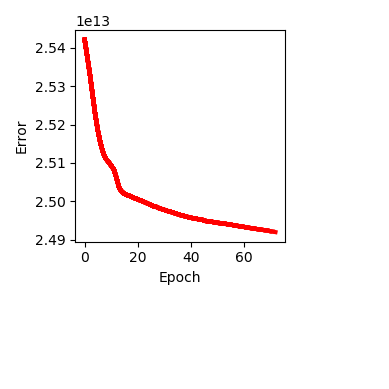

/home/leo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: 

In [132]:
# loss function
# criterion = torch.nn.MSELoss(reduction = "sum")

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# use of GPU flag
use_gpu = False

# load model on GPU
if use_gpu:
    model = model.cuda()

# number of epochs
epochs = 1000000

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# loss plot
fig, ax = plt.subplots(figsize = (3, 3), tight_layout = True)
# fig, ax = plt.subplots()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

# plt.legend()

# plt.axis([0,1000,0,10])
# plt.show()

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 100

for nepoch in tqdm_notebook(range(epochs)):
    
#     print("epoch: {0}".format(nepoch))
    
    # train
    epoch_train_loss = 0
    
    for data in trainLoader:
        
        data = data[0]
        
        optimizer.zero_grad()
        
        if use_gpu:
            
            data = data.type(torch.FloatTensor).cuda()
            outputs = model.forward(data.type(torch.FloatTensor).cuda())
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor).cuda())
            
        else:
                        
            data = generateDeltas(data, 0).type(torch.FloatTensor)
#             generateDeltas(data, 0)
            outputs = model.forward(data.type(torch.FloatTensor))
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor))
        
#         loss = criterion(outputs, data)
        # use KLD + MSE
        loss = loss_function(outputs, data, mu, logvar)
#         print(loss)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_loss[nepoch] = epoch_train_loss
    
#     print(train_loss)
    
#     # test
#     epoch_test_loss = 0
    
#     for data in testLoader:
        
#         data = data[0]
        
#         if use_gpu:
            
#             data = data.type(torch.FloatTensor).cuda()
#             outputs = model.forward(data.cuda())
#             mu, logvar = model.encoder.forward(data.type(torch.FloatTensor).cuda())
#         else:
#             data = data.type(torch.FloatTensor)
            
#             outputs = model.forward(data)
            
#             mu, logvar = model.encoder.forward(data.type(torch.FloatTensor))
        
# #         loss = criterion(outputs, data)
#         loss = loss_function(outputs, data, mu, logvar)
        
#         epoch_test_loss += loss.item()
    
#     test_loss[nepoch] = epoch_test_loss
    
#     # plot loss
    ax.plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
#     ax.plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green") 
    
    fig.canvas.draw()
#     plt.pause(0.000005)
    
        # Early stopping
#     if epoch_test_loss > prior_test_error:
#         count_early_stop += 1
#         print("early stopping counter: ", count_early_stop)
#     else: 
#         count_early_stop = 0
    
#     # update prior test error
#     prior_test_error = epoch_test_loss
    
#     # analyze early stopping
#     if count_early_stop > threshold_early_stop:
        
#         print("Early stopping in epoch: ", nepoch)
#         break


6


<IPython.core.display.Javascript object>


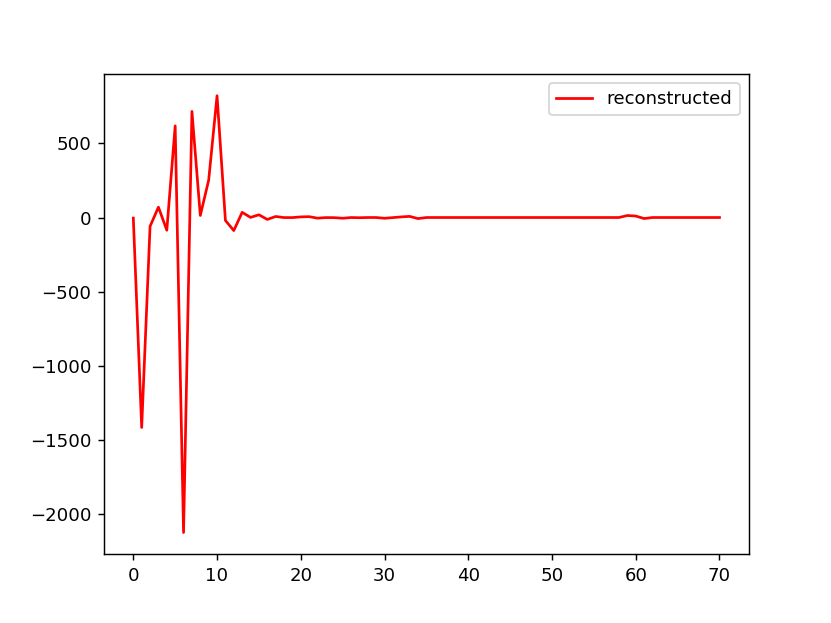

In [154]:
# reconstruction
print(len(list(trainLoader)))

lID = 0

reconstructedLightCurve = model.forward(generateDeltas(list(trainLoader)[lID][0], 0))

# print(reconstructedLightCurve.shape)
# print(list(testLoader)[0][0].shape)
# # display(reconstructedLightCurve.detach().numpy()[0].shape)
# print(list(testLoader)[0][0][0, 1, :].shape)

fig, ax = plt.subplots()

ax.plot(reconstructedLightCurve.detach().numpy()[0, 1, :], label = "reconstructed", color = "red")

# ax.plot(list(trainLoader)[lID][0][0, 1, :].detach().numpy(), label = "original", color = "green")

plt.legend()

In [147]:
list(trainLoader)[0][0].shape

torch.Size([256, 6, 4, 72])

### <font color='red'>Things to do:</font>
- Define metrics for evaluate models